Test our First Implementation of the Model

In [1]:
%matplotlib inline

from IPython.display import display

import numpy as np
 
from load_mock import load_penultimate_best_fit_mock
import matplotlib.pyplot as plt
from halotools.mock_observables import return_xyz_formatted_array
from halotools.mock_observables import delta_sigma
from halotools.mock_observables import tpcf

%config InlineBackend.figure_format='retina'
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0

In [2]:
# Bolshoi P om=0.30711
# Planck13 Om=0.307
#from astropy.cosmology import Planck13 as cosmo
#print(cosmo.H(0))

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.307)
h=0.7

In [10]:
# Read in the Halo Data
# get Mhalo / frac_sm100_by_smtot / frac_sm10_by_sm100
# Get x,y,z coordinates as well for lensing

#  Select which data you wish to be loaded into memory
galprops = list(('sm', 'sfr', 'obs_sm', 'obs_sfr', 'icl', 'mvir',
                 'halo_id', 'upid', 'mpeak','x','y','z'))

#  UM directory
root_dirname = "/Users/alexie/Work/HSC/UniverseMachine/Data"

# All 144 subvolumes to load the whole mock
subvolumes=np.arange(144)
mock = load_penultimate_best_fit_mock(galprops=galprops, 
                                      root_dirname=root_dirname,
                                     subvolumes=subvolumes)

um_obs_sm =np.log10(mock['obs_sm'])
um_obs_sm_icl =np.log10(mock['obs_sm']+mock['icl'])

# These are the parameters of the model
# scatter
# frac_sm100_by_smtot
# frac_sm10_by_sm100
# to start, set these by the existing UM catalog

Total runtime = 3.44 seconds


In [4]:
# Make the model

# This returns m10, m100, smtot
#sm_profile_from_mhalo(mhalo,
#        log_mhalo_coeff, normalization_param, random_scatter_in_dex,
#        frac_sm100_by_smtot, frac_sm10_by_sm100)

#        return m10, m100, smtot

In [5]:
# TO DO list: get fancy and add a bootstrap error here?

def compute_smf(sm_array,volume, nb, sm_min, sm_max):
    """
    Parameters
    ----------
    sm_array: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^-3 
        
    nb : number of bins
    
    sm_min : min of x axis
    
    sm_max : max of y axis

    Returns
    -------
    x : ndarray
        x axis of SMF in units of log10 M*

    y : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    err : ndarray
        Poisson error
    """

    smf, bin_edges = np.histogram(sm_array,bins=nb,range=[sm_min,sm_max])
    
    # bin width in dex
    mass_bin_width = bin_edges[1]-bin_edges[0]
    
    # Poison error
    err = np.sqrt(smf)
    
    # Normalize
    smf = smf/volume/mass_bin_width
    
    # Also normalize the err
    err = err/volume/mass_bin_width
    
    # X-axis
    x = bin_edges[:-1]+mass_bin_width/2.0
    
    return x, smf, err

In [6]:
# Computs SMFs

# Compute Bolshoi SMF
#Lbox=250 Mpc/h
bolshoi_volume= np.power(250/h,3) # Mpc/h converted to real h values
bolshoi_x, bolshoi_smf, bolshoi_err = compute_smf(um_obs_sm,bolshoi_volume, 20, 10.0, 12.8)
bolshoi_x_icl, bolshoi_smf_icl, bolshoi_err_icl = compute_smf(um_obs_sm_icl,bolshoi_volume, 20, 10.0, 12.8)

# Compute HSC SMF
# Read in the HSC data
hscdata=np.loadtxt('/Users/alexie/Work/HSC/MassiveBCGs/UMModel/mass_prof_cam/Data/s16a_massive_z0.3_0.5_m100_11.6_twoCols.txt')
M100 = hscdata[:,0]
M10  = hscdata[:,1]

zmin = 0.29
zmax = 0.51
hsc_area = 146 # deg^2

# Comoving Volume over a redshift interval per steradian (Mpc^3)
# This creates a weired plotting error
# ????
volume = 81388104.988  # Songs number

# Gives units which creates a plotting error ????
# output volume is not per steradian, so we don't need the 4*np.pi
#volume=(cosmo.comoving_volume(zmax)-cosmo.comoving_volume(zmin))* (hsc_area/41254.0) # Mpc^-3

#object that has units
# volume.value => gets rid of the units

# => why does this not give the right answer?
print(volume)

#redshift_factor = (cosmo(zmax, /VOL)-cosmo(zmin, /VOL))
#boot_vol[i]  = redshift_factor*1.0*(boot_area[i]/41254.0)*4*!pi ; Mpc^-3

# Compare here
hsc_x, hsc_smf, hsc_err = compute_smf(M100,volume, 8, 11.6, 12.2)
print(hsc_x)
print(hsc_smf)
print(hsc_err)


81388104.988
[ 11.6375  11.7125  11.7875  11.8625  11.9375  12.0125  12.0875  12.1625]
[  1.28274273e-04   7.29017260e-05   4.09560259e-05   1.85121237e-05
   7.37208466e-06   4.09560259e-06   3.27648207e-07   3.27648207e-07]
[  4.58414853e-06   3.45587325e-06   2.59028651e-06   1.74147411e-06
   1.09896550e-06   8.19120517e-07   2.31682269e-07   2.31682269e-07]


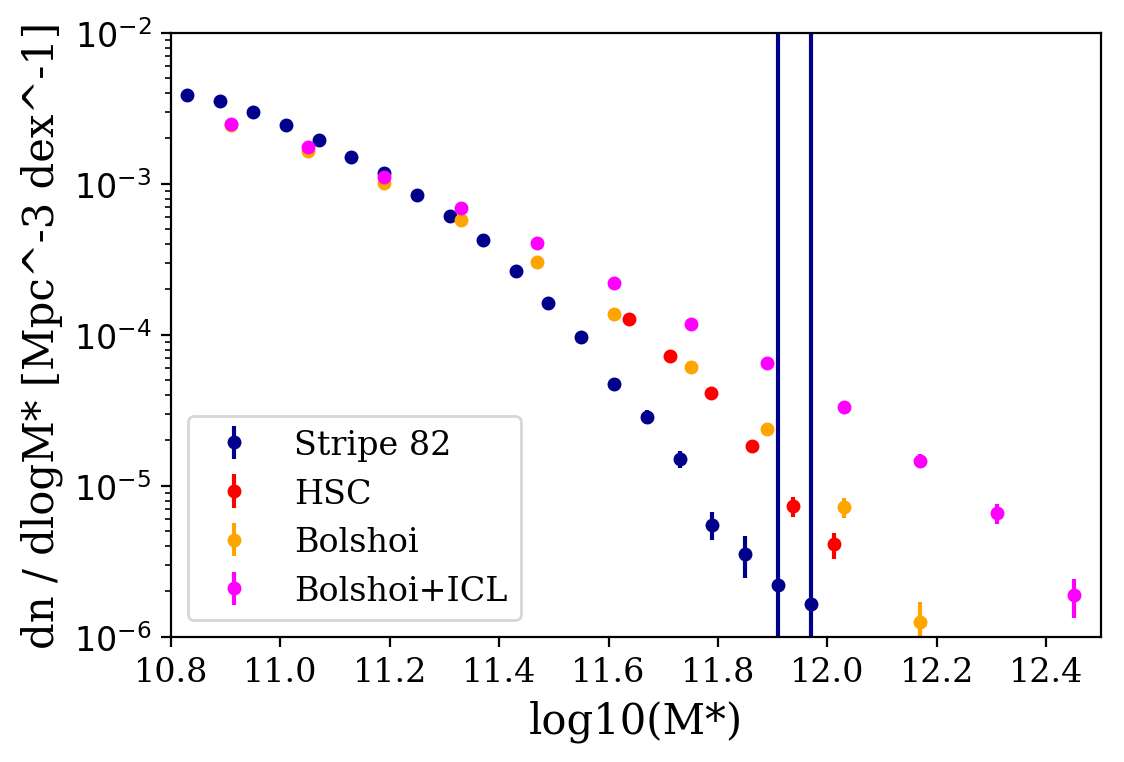

In [7]:
# Compare the SMF

# Read in Stripe 82 data
s82=np.loadtxt('/Users/alexie/Work/HSC/MassiveBCGs/UMModel/mass_prof_cam/Data/s82_total_smf_0.15_0.43.txt')

fig,ax = plt.subplots(1,1)

#ax.ylim=(1e-6,1e-2)  # not working?
yscale = ax.set_yscale('log')
xlim = ax.set_xlim(xmin = 10.8, xmax=12.5)
ylim = ax.set_ylim(ymin = 1e-6, ymax=1e-2)
xlabel = ax.set_xlabel('log10(M*)', fontsize=15)
ylabel = ax.set_ylabel('dn / dlogM* [Mpc^-3 dex^-1]', fontsize=15)

ax.errorbar(s82[:,0], s82[:,1], yerr = s82[:,2], fmt = '.', marker = 'o',  ms = 4.0, color = 'darkblue', label = 'Stripe 82')
ax.errorbar(hsc_x, hsc_smf, yerr = hsc_err, fmt = '.', marker = 'o', ms = 4.0, color = 'red', label = 'HSC')
ax.errorbar(bolshoi_x, bolshoi_smf, yerr = bolshoi_err, fmt = '.', marker = 'o', ms = 4.0, color = 'orange', label = 'Bolshoi')
ax.errorbar(bolshoi_x_icl, bolshoi_smf_icl, yerr = bolshoi_err_icl, fmt = '.', marker = 'o', ms = 4.0, color = 'magenta', label = 'Bolshoi+ICL')
ax.legend(loc='lower left')

In [15]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck', redshift=0)
# halocat.fname
# halocat.halo_table.keys()

In [18]:
halocat.ptcl_table

InvalidCacheLogEntry: 
You tried to load a cached particle catalog with the following characteristics:

simname = ``b'bolplanck'``
ptcl_version_name = ``halotools_v0p4``  (set by sim_defaults.default_version_name)
redshift = ``-0.0023``

There is no matching catalog in cache within dz_tol = 0.05 of these inputs.
There are no simulations matching your input simname.


In [23]:
#download_initial_halocat.py
# from astropy.table import Table
# fname = '/Users/alexie/.astropy/cache/halotools/particle_catalogs/bolplanck/hlist_1.00231.particles.halotools_v0p4.hdf5'
# particles = Table.read(fname, path='data')

# particles['x'] # in Mpc/h

In [22]:
from halotools

249.999878

In [8]:
# Compute lensing from mock
#download_additional_halocat.py bolplanck rockstar halotools_v0p4 0

#Lbox = 100.0   # 100/h
#period = np.array([Lbox,Lbox,Lbox])

# Read in the Galaxy File
gal_list = np.loadtxt('/Users/alexie/Work/HSC/CompareHydroProfiles/DataFromMBII/mblack2_z0.3_m100_11.6_11.8.asc')
        
#        x=gal_list[:,2]
#        y=gal_list[:,3]
#        z=gal_list[:,4]
        
        # These are in units of kpc, put into Mpc
#        x=x/1000.0
#        y=y/1000.0
#        z=z/1000.0
                
        # Format the array for halotools
#        galpos = return_xyz_formatted_array(x, y, z)

        # Read in the DM file
#        dm_pos = np.fromfile('./position_data/dm/position',dtype=(np.float64,3))
        
        # Don't need this one for the DM, all the same mass
        #dm_mass = numpy.fromfile('./position_data/dm/mass',dtype=numpy.float64)

        # These are in units of kpc, put into Mpc
#        x=dm_pos[:,0]/1000.0
#        y=dm_pos[:,1]/1000.0
#        z=dm_pos[:,2]/1000.0
                
        # Format the array for halotools
#        dmpos = return_xyz_formatted_array(x, y, z)
        
#        ntotparticles = 5754585088.0
#        downsampling_factor = ntotparticles/10000000.0
#        print "downsampling factor"
#        print downsampling_factor

        #numpy.logspace(start, stop, num=50, endpoint=True, base=10.0, dtype=None)[source]
        # This is in Mpc/h comoving
#        rp_bins = np.logspace(-1.5,1,10)
#        print 'Rp bins'
#        print rp_bins

        # We need an array with the particle masses
        # In our case, the particle masses are all the same
        # 8.723e+9 I think
        #particle_mass_array = x # sample lenth as position array
        # For the case when all the masses are constant, one can just use a single float which is the particle mass
#        particle_mass = 0.00110449e+10 
        
        # This is the new version of Delta Sigma
        # This is the new version of Delta Sigma
        #def delta_sigma(galaxies, particles, particle_masses, downsampling_factor,
        #rp_bins, period, cosmology=default_cosmology, num_threads=1,
        #approx_cell1_size=None, approx_cell2_size=None):
#        r, ds = delta_sigma(galpos, dmpos, particle_mass, downsampling_factor, rp_bins, Lbox)

        # units are in Msun / Mpc^2 ... divide by 1e12
#        ds = ds/1e12
        
#        table = {'rmpc': r,'deltasigma': ds}   
        
#        ascii.write(table, 'ds_dm_11.6_11.8.dat', formats={'rmpc': '%.5f', 'deltasigma': '%.5f'},Writer=ascii.CommentedHeader)
        #ascii.write(table

<Container object of 3 artists>

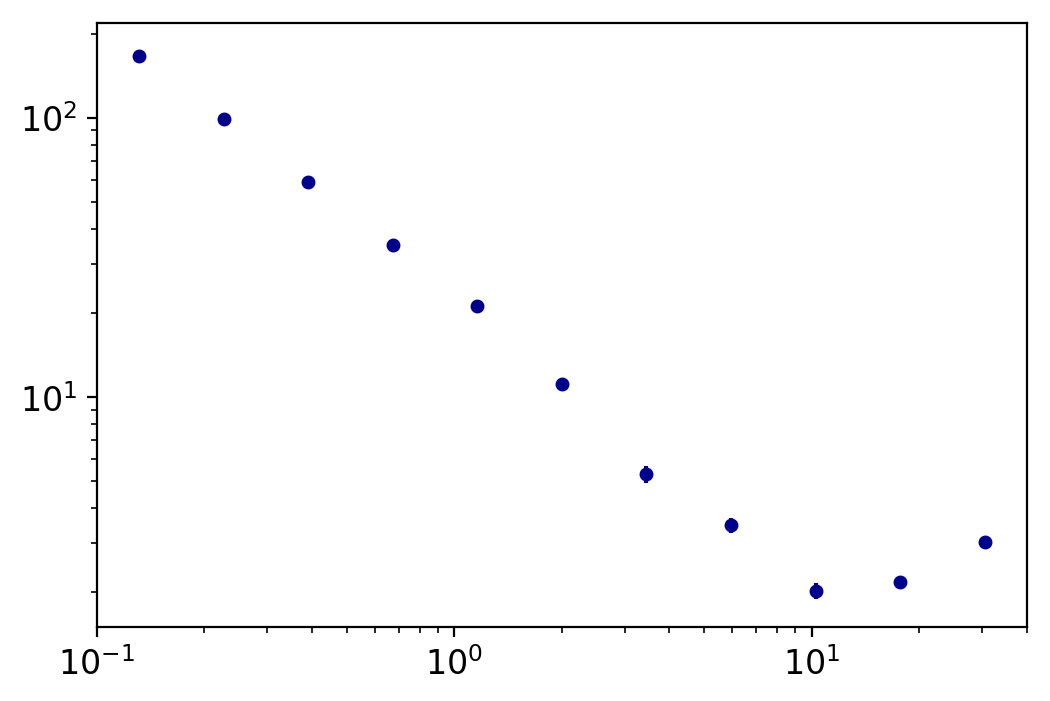

In [9]:
# !!!!! h values here !!!
# Compare with lensing here
dsarray = np.loadtxt('/Users/alexie/Work/HSC/MassiveBCGs/UMModel/mass_prof_cam/Data/s16a_massive_z0.3_0.5_m100_11.6.asc')

r = dsarray[:,0]
ds = dsarray[:,1]
ds_err = dsarray[:,2]

plt.figure()
plt.xscale('log')
# ???? gives error?
#plt.xlabel('r(mpc/h)')
plt.yscale('log')
#plt.ylabel('DS')
#plt.plot(ds[:,0], ds[:,1], '-',label = 'bb1');
plt.errorbar(r,ds, yerr = ds_err, fmt = '.', marker = 'o', ms = 4.0, color = 'darkblue', label = 'HSC Data')
#plt.ylim(1E0, 1E7)
#plt.legend();